Optimal Transport with Linear Programming
=========================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.

$\boxed{\text{Pour valider le cours il faut faire un rapport d'environ 2 pages pour montrer qu'on a compris le notebook et appliquer à notre propre data}}$ 
$\boxed{\text{ce qu'il se passe ici.}}$ 

This numerical tours details how to solve the discrete optimal transport
problem (in the case of measures that are sums of Diracs) using linear
programming.

You need to install [CVXPY](https://www.cvxpy.org/). _Warning:_ seems to not be working on Python 3.7, use rather 3.6.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import random

Optimal Transport of Discrete Distributions
------------------------------------------

We consider two dicretes distributions
$$ \al = \sum_{i=1}^n a_i \de_{x_i} \qandq 
   \be = \sum_{j=1}^m b_j \de_{y_j}. $$
   
where $n,m$ are the number of points, $\de_x$ is the Dirac at
location $x \in \RR^d$, and $(x_i)_i, (y_j)_j$ are the positions of the diracs in $\RR^d$. 

Dimensions $(n,m)$ of the coulds.

In [19]:
n = 90
m = 120

Generate the point clouds $X=(x_i)_i$ and $Y=(y_j)_j$.

Où ici, les variables $(X_i)_i$ représentent des variables i.i.d $\mathcal{N}(0_{\mathbb{R}^2}, 0.3 I_2)$. Tandis que les $(Y_i)_i$ sont des mixtures gaussiennes i.i.d dont on peut facilement déterminer les paramètres. 

Nous allons générer plusieurs types de nuages de données, avec différentes dispositions dans l'espace: 

- 1) Exemple initiale du Notebook: l'échantillon de départ est issu d'une distribution Gaussienne $\mathcal{N}(0, 0.3)$, tandis que celui d'arrivée, est une Mixture Gaussienne à 3 modes. 
- 2) Échantillon de départ : issu d'une loi uniforme le long du cercle unité / Échantillon cible: issu d'une loi uniforme $\mathcal{U}([-1, 1])$
- 3) Échantillon de départ : issu d'une gaussienne standard $\mathcal{N}(0, 1)$ / Échantillon cible: issu d'une loi uniforme sur une forme plus complexe, une spirale. 
- 4) Échantillon de départ : Loi uniforme dans le cercle unité / Échantillon cible : Loi uniforme sur un ensemble discret, à savoir les angles du carré $[-1, 1] \times [-1, 1]$, i.e, un nuage dispersé sur un ensemble continu, vers un nuage concentré sur un ensemble discret


In [20]:
## Example 1
gauss = lambda q,a,c: a*np.random.randn(2, q) + np.transpose(np.tile(c, (q,1)))
X_1 = np.random.randn(2,n)*.3
Y_1 = np.hstack((gauss(int(m/2),.5,[0,1.6]),np.hstack((gauss(int(m/4),.3,[-1,-1]),gauss(int(m/4),.3,[1,-1])))))

## Example 2
theta = np.random.rand(n)*2*np.pi
x_2 = np.cos(theta)
y_2 = np.sin(theta)
X_2 = [np.cos(theta), np.sin(theta)] + np.random.randn(2,n)*.05 #Cercle bruité
Y_2 = [np.random.rand(m)*2-1, np.zeros(m)] + np.random.randn(2,m)*.05

## Example 3
a_ = 0.5 
b_ = 1    
t = np.linspace(0, 2 * np.pi * b_, m)  
r = a_ * t
sigma = 0.05 
x_3 = r * np.cos(t)
y_3 = r * np.sin(t)
X_3 = np.random.randn(2,n)*.3
Y_3 = np.stack((r * np.cos(t), r * np.sin(t)), axis=1).T + (np.random.randn(2, m)*sigma) #Spirale bruitée

## Example 4
theta_bis = np.random.rand(n)*2*np.pi
X_4 = [np.cos(theta_bis), np.sin(theta_bis)] + np.random.randn(2,n)*.05 #Cercle bruité
x_4 = np.cos(theta_bis)
y_4 = np.sin(theta_bis)
Y_4 = np.array(random.choices([[-1,1],[1,-1],[-1,-1],[1,1]], k=m)).T



Generate the weights $a,b$.

In [21]:
normalize = lambda a: a/np.sum(a)
a = normalize(np.random.rand(n, 1))
b = normalize(np.random.rand(m, 1))

Helper function for display of clouds.

In [22]:
myplot = lambda x,y,ms,col: plt.scatter(x,y, s=ms*20, edgecolors="k", c=col, linewidths=2)

In [23]:
def plot_points(X, Y, a, b, x=None, y=None, label_density=None, title=None):
    
    plt.figure(figsize=(8, 6))
    plt.axis("off")

    for i in range(len(a)):
        myplot(X[0, i], X[1, i], a[i] * len(a) * 10, 'blue')

    for j in range(len(b)):
        myplot(Y[0, j], Y[1, j], b[j] * len(b) * 10, 'red')

    all_x = np.concatenate([X[0, :], Y[0, :]])
    all_y = np.concatenate([X[1, :], Y[1, :]])
    x_min, x_max = all_x.min() - 0.1 * abs(all_x.ptp()), all_x.max() + 0.1 * abs(all_x.ptp())
    y_min, y_max = all_y.min() - 0.1 * abs(all_y.ptp()), all_y.max() + 0.1 * abs(all_y.ptp())
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.scatter([], [], s=100, color='blue', label='Group X')  
    plt.scatter([], [], s=100, color='red', label='Group Y')   
    if x is not None:
        plt.scatter(x, y, s=100, color='green', label=label_density)
         
    plt.legend(loc='upper right', fontsize=12, frameon=False)

    plt.title(title, fontsize=14, fontweight='bold')
    plt.show()

Display the point clouds.
The size of each dot is proportional to its probability density weight.

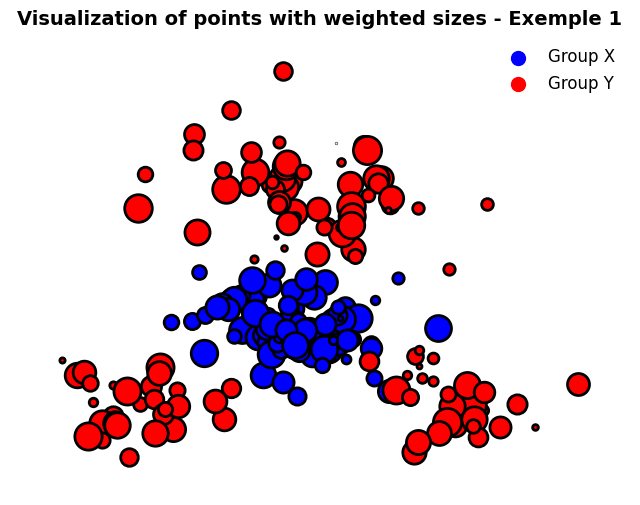

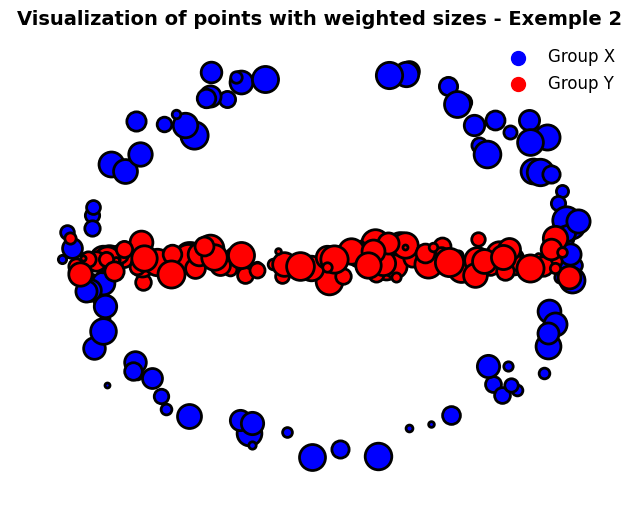

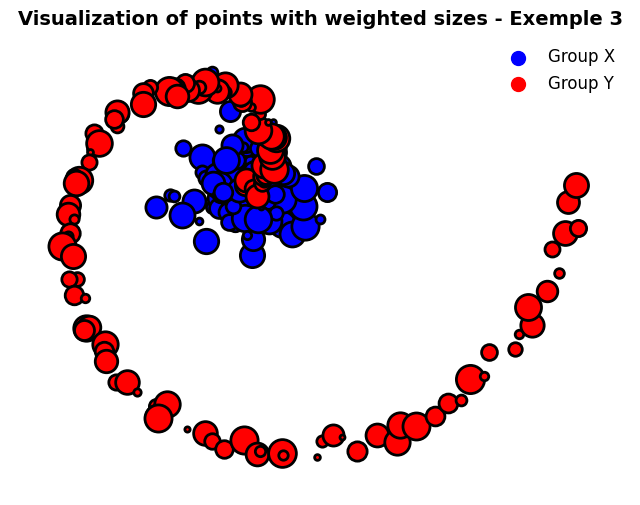

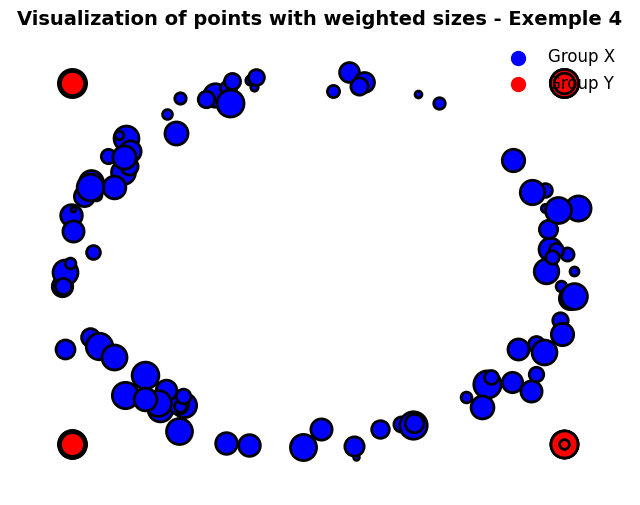

In [24]:
plot_points(X_1, Y_1, a, b, title = "Visualization of points with weighted sizes - Exemple 1")
plot_points(X_2, Y_2, a, b, title = "Visualization of points with weighted sizes - Exemple 2")
plot_points(X_3, Y_3, a, b, title = "Visualization of points with weighted sizes - Exemple 3")
plot_points(X_4, Y_4, a, b, title = "Visualization of points with weighted sizes - Exemple 4")

Compute the cost matrix $C_{i,j} := \mid \mid x_i-x_j\mid\mid^2$.

In [25]:
def distmat(x,y):
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)
C_1 = distmat(X_1,Y_1)
C_2 = distmat(X_2,Y_2)
C_3 = distmat(X_3,Y_3)
C_4 = distmat(X_4,Y_4)

Define the optimiztion variable $P$.

In [26]:
P_1 = cp.Variable((n,m))
P_2 = cp.Variable((n,m))
P_3 = cp.Variable((n,m))
P_4 = cp.Variable((n,m))

Define the set of discrete couplings between $\al$ and $\be$
$$ U(a,b) := \enscond{ P \in \RR_+^{n \times m} }{
     \forall i, \sum_j P_{i,j} = a_i, \:
     \forall j, \sum_i P_{i,j} = b_j }. $$

In [27]:
u = np.ones((m,1))
v = np.ones((n,1))
U_1 = [0 <= P_1, cp.matmul(P_1,u)==a, cp.matmul(P_1.T,v)==b]
U_2 = [0 <= P_2, cp.matmul(P_2,u)==a, cp.matmul(P_2.T,v)==b]
U_3 = [0 <= P_3, cp.matmul(P_3,u)==a, cp.matmul(P_3.T,v)==b]
U_4 = [0 <= P_4, cp.matmul(P_4,u)==a, cp.matmul(P_4.T,v)==b]

The Kantorovitch formulation of the optimal transport reads
$$ P^\star \in \uargmin{P \in U(a,b)} \sum_{i,j} P_{i,j} C_{i,j}.  $$
Solve it using CVXPY

In [28]:
objective = cp.Minimize(cp.sum(cp.multiply(P_1,C_1)) )
prob = cp.Problem(objective, U_1)
result_1 = prob.solve()

objective = cp.Minimize(cp.sum(cp.multiply(P_2,C_2)) )
prob = cp.Problem(objective, U_2)
result_2 = prob.solve()

objective = cp.Minimize(cp.sum(cp.multiply(P_3,C_3)) )
prob = cp.Problem(objective, U_3)
result_3 = prob.solve()

objective = cp.Minimize(cp.sum(cp.multiply(P_4,C_4)) )
prob = cp.Problem(objective, U_4)
result_4 = prob.solve()

/opt/anaconda3/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


An optimal coupling $P^\star$ can be shown to be a sparse matrix
with less than $n+m-1$ non zero entries. An entry $P_{i,j}^\star \neq 0$
should be understood as a link between $x_{i}$
and $y_{j}$ where an amount of mass equal to $P_{i,j}^\star$ is transfered.

Check that the number of non-zero entries in $P^\star$ is $n+m-1$. Beware that we are using an interior point method here, so that entries of $P^\star$ are nevery exactly 0.

In [29]:
print("Number of non-zero: %d (n + m-1 = %d)" %(len(P_1.value[P_1.value>1e-5]), n + m-1))

Number of non-zero: 208 (n + m-1 = 209)


Display the solution coupling.

In [30]:
def plot_solution(P):
    plt.figure(figsize=(8, 6))
    plt.imshow(P.value, cmap='viridis', interpolation='nearest')

    plt.colorbar(label='Valeurs de P')
    plt.title("Solution du Problème d'Optimisation de Kantorovitch Discret")

    plt.xlabel('Index Y')
    plt.ylabel('Index X')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

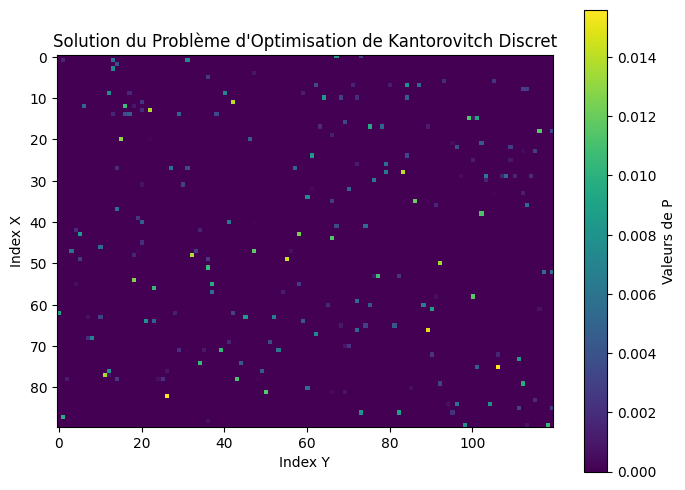

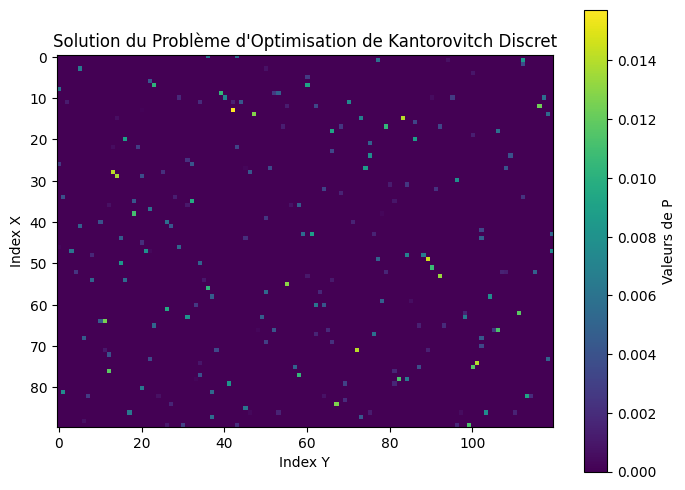

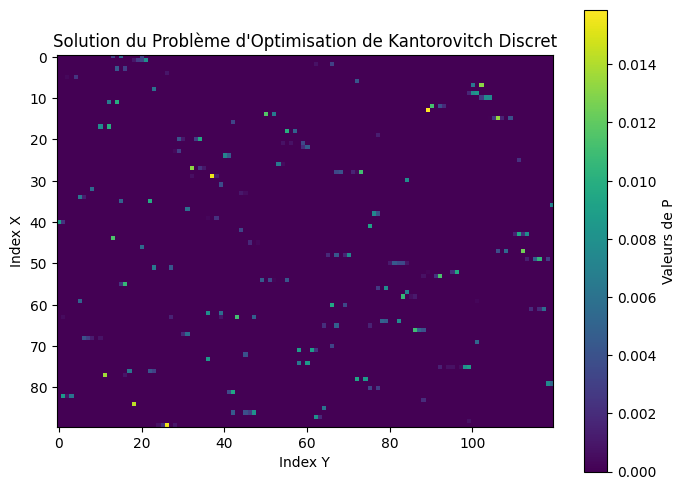

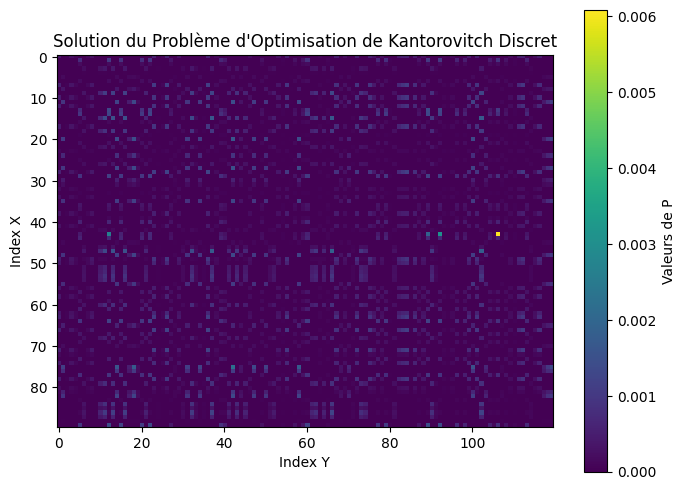

In [31]:
plot_solution(P_1)
plot_solution(P_2)
plot_solution(P_3)
plot_solution(P_4)

Display the connexion defined by the optimal coupling.

In [32]:
def plot_matching(X, Y, P):    
    I, J = np.nonzero(P.value > 1e-5)

    plt.figure(figsize=(10, 7))
    plt.axis('off')

    for k in range(len(I)):
        # Calculer les coordonnées des points de X et Y et tracer une ligne entre eux
        h = plt.plot(np.hstack((X[0, I[k]], Y[0, J[k]])),
                    np.hstack(([X[1, I[k]], Y[1, J[k]]])), 'k', lw=1)

    for i in range(len(a)):
        myplot(X[0, i], X[1, i], a[i] * len(a) * 15, 'b')

    for j in range(len(b)):
        myplot(Y[0, j], Y[1, j], b[j] * len(b) * 15, 'r')
    
    all_x = np.concatenate([X[0, :], Y[0, :]])
    all_y = np.concatenate([X[1, :], Y[1, :]])
    x_min, x_max = all_x.min() - 0.1 * abs(all_x.ptp()), all_x.max() + 0.1 * abs(all_x.ptp())
    y_min, y_max = all_y.min() - 0.1 * abs(all_y.ptp()), all_y.max() + 0.1 * abs(all_y.ptp())    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title("Connexions optimales entre les points X et Y")
    plt.xlabel("Coordonnée X")
    plt.ylabel("Coordonnée Y")
    plt.show()

In [45]:
def plot_matching_multiples(data_list, num_cols=2):
    """
    Trace plusieurs graphiques côte à côte représentant les connexions optimales entre des ensembles de points X et Y.

    Parameters:
    -----------
    data_list : list of tuples
        Liste contenant les triplets (X, Y, P) pour chaque graphique.
        - X : ndarray (2, n) - Coordonnées des points de départ.
        - Y : ndarray (2, m) - Coordonnées des points d'arrivée.
        - P : ndarray (n, m) - Matrice de poids indiquant les connexions optimales.
    num_cols : int
        Nombre de colonnes de sous-graphiques à afficher (par défaut : 2).
    """
    num_plots = len(data_list)
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculer le nombre de lignes nécessaires
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = np.array(axes).reshape(-1)  # Aplatir pour un accès simple

    for idx, (X, Y, P) in enumerate(data_list):
        ax = axes[idx]
        ax.axis('off')

        I, J = np.nonzero(P.value > 1e-5)
        for k in range(len(I)):
            # Tracer une ligne entre les points correspondants
            ax.plot(np.hstack((X[0, I[k]], Y[0, J[k]])),
                    np.hstack((X[1, I[k]], Y[1, J[k]])), 'k', lw=1)

        # Tracer les points de X et Y
        for i in range(X.shape[1]):
            ax.scatter(X[0, i], X[1, i], s=a[i] * len(a) * 150, c='b')
        for j in range(Y.shape[1]):
            ax.scatter(Y[0, j], Y[1, j], s=b[j] * len(b) * 150, c='r')
        
        # Ajuster les limites
        all_x = np.concatenate([X[0, :], Y[0, :]])
        all_y = np.concatenate([X[1, :], Y[1, :]])
        x_min, x_max = all_x.min() - 0.1 * abs(all_x.ptp()), all_x.max() + 0.1 * abs(all_x.ptp())
        y_min, y_max = all_y.min() - 0.1 * abs(all_y.ptp()), all_y.max() + 0.1 * abs(all_y.ptp())
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        ax.set_title(f"Optimal Mapping of the two point clouds -  Example {idx + 1}")
    
    # Supprimer les axes inutilisés
    for ax in axes[num_plots:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


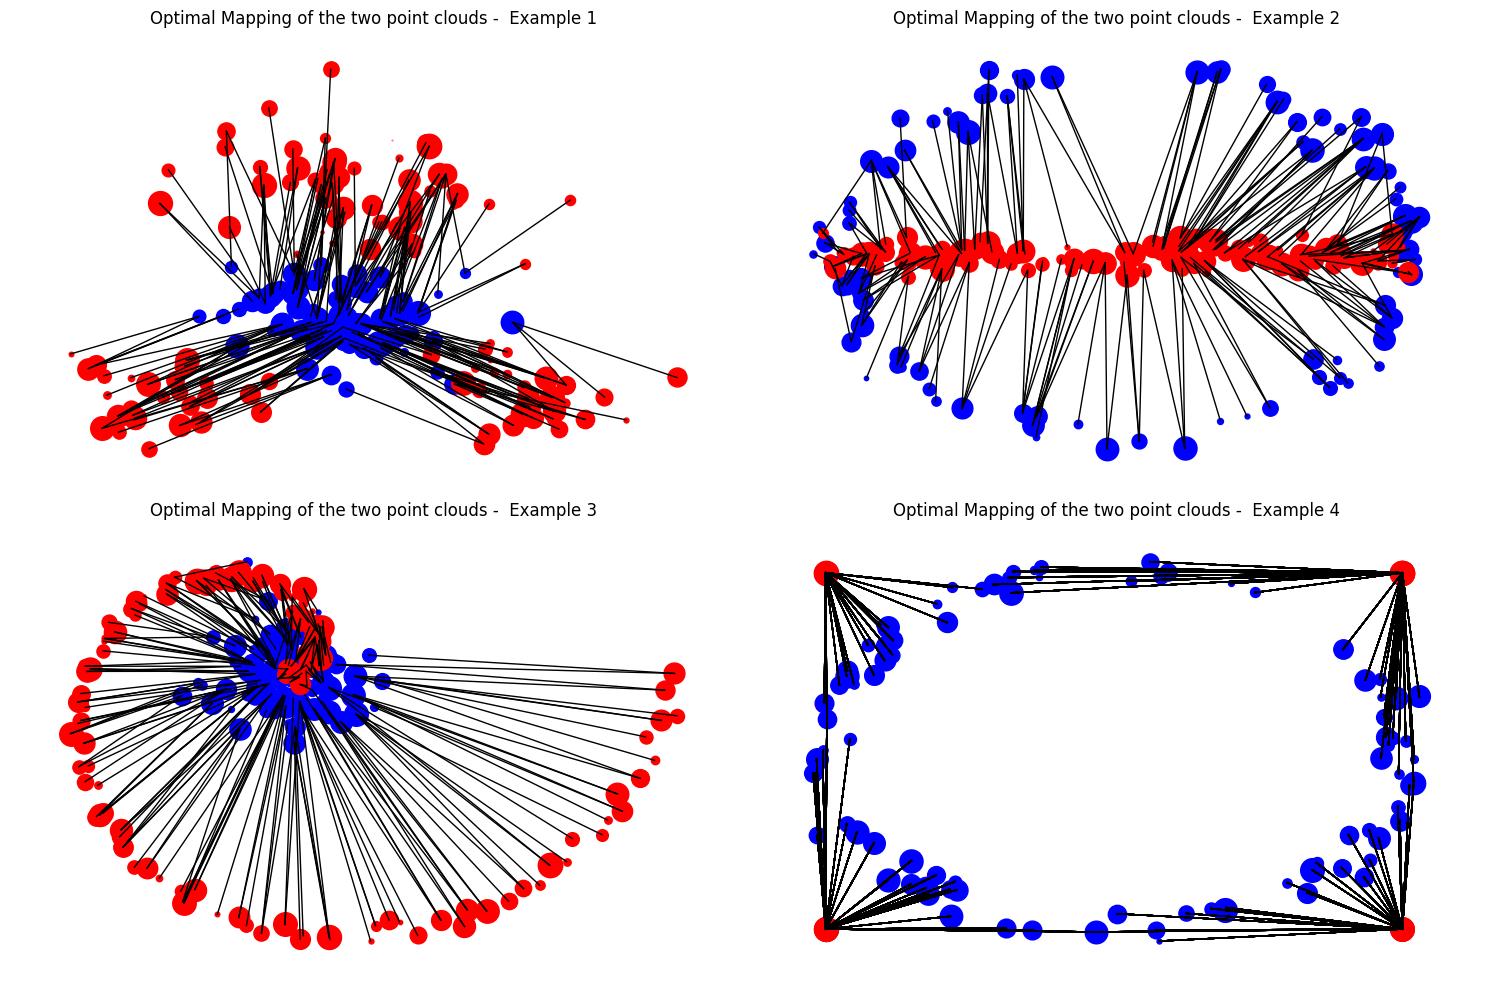

In [46]:
plot_matching_multiples([(X_1, Y_1, P_1), (X_2, Y_2, P_2), (X_3, Y_3, P_3), (X_4, Y_4, P_4)], num_cols=2)

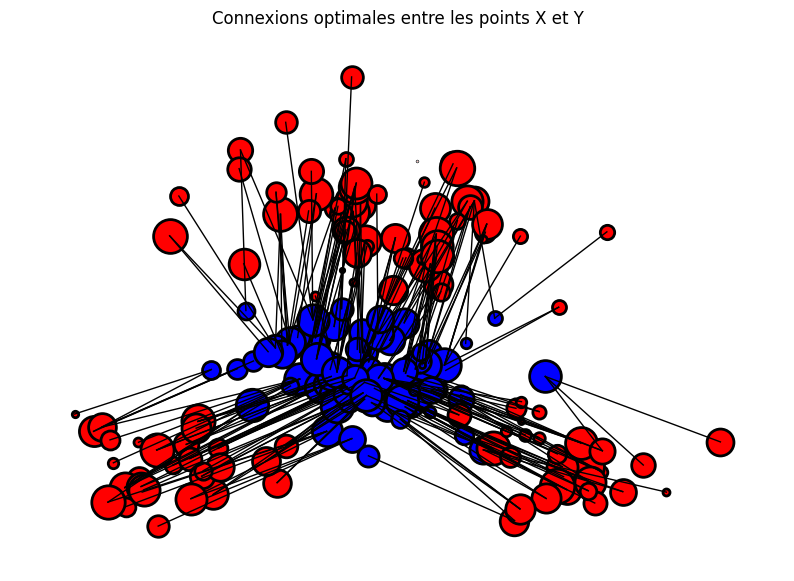

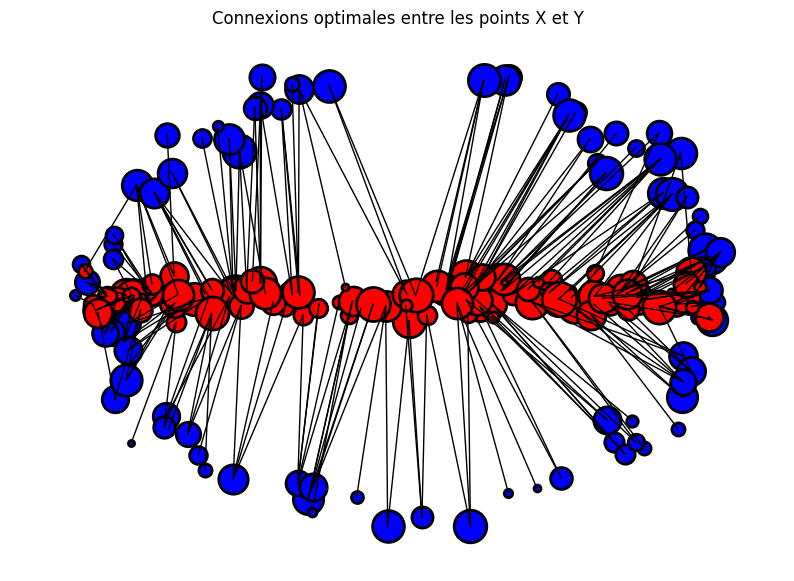

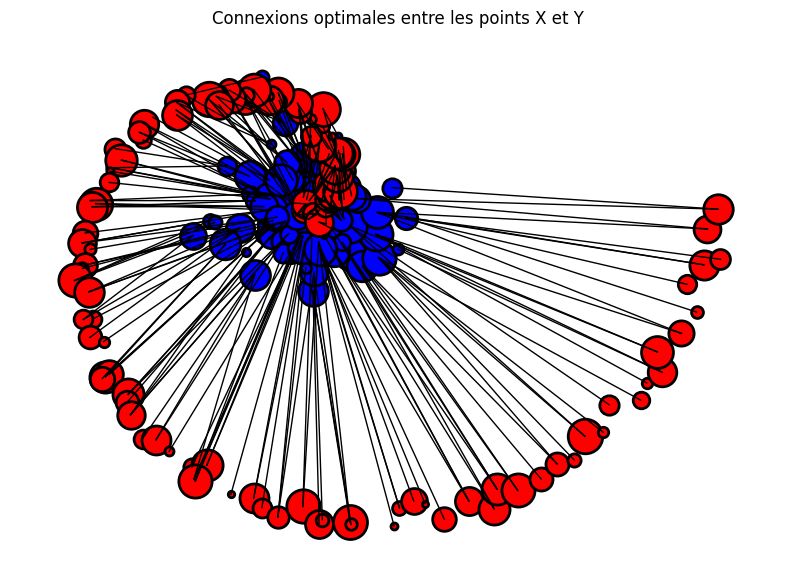

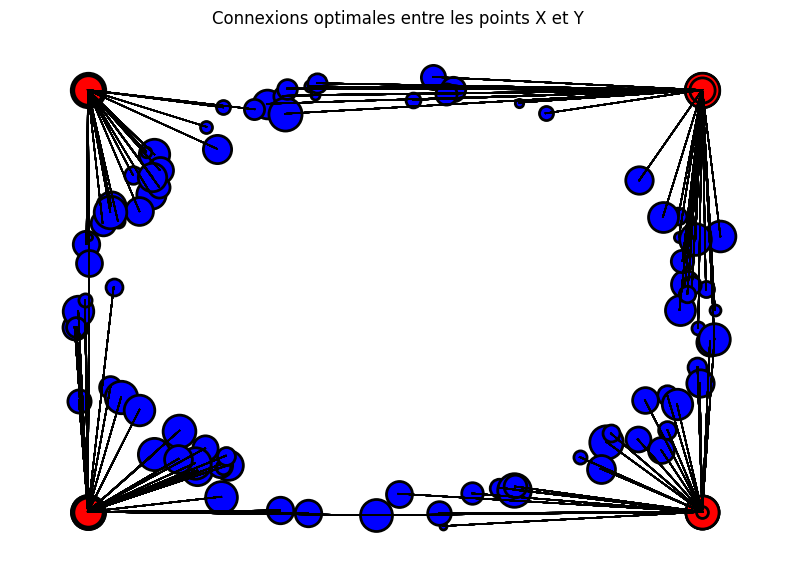

In [42]:
plot_matching(X_1, Y_1, P_1)
plot_matching(X_2, Y_2, P_2)
plot_matching(X_3, Y_3, P_3)
plot_matching(X_4, Y_4, P_4)

Displacement Interpolation
--------------------------
For any $t \in [0,1]$, one can define a distribution $\mu_t$ such
that $t \mapsto \mu_t$ defines a geodesic for the Wasserstein metric.


Since the $W_2$ distance is a geodesic distance, this geodesic path solves the
following variational problem

$$ \mu_t = \uargmin{\mu} (1-t)W_2(\al,\mu)^2 + t W_2(\be,\mu)^2. $$
This can be understood as a generalization of the usual Euclidean
barycenter to barycenter of distribution. Indeed, in the case that
$\al = \de_{x}$ and $\be=\de_y$, one has $\mu_t=\de_{x_t}$ where $ x_t =
(1-t)x+t y $.


Once the optimal coupling $P^\star$ has been computed, the
interpolated distribution is obtained as

$$ \mu_t = \sum_{i,j} P^\star_{i,j} \de_{(1-t)x_{i} + t y_{j}}. $$

Find the $i,j$ with non-zero $P_{i,j}^\star$.

In [47]:
I_1,J_1 = np.nonzero(P_1.value>1e-5)
Pij_1 = P_1.value[I_1,J_1]
I_2,J_2 = np.nonzero(P_2.value>1e-5)
Pij_2 = P_2.value[I_2,J_2]
I_3,J_3 = np.nonzero(P_3.value>1e-5)
Pij_3 = P_3.value[I_3,J_3]
I_4,J_4 = np.nonzero(P_4.value>1e-5)
Pij_4 = P_4.value[I_4,J_4]

Display the evolution of $\mu_t$ for a varying value of $t \in [0,1]$.

In [18]:
def plot_interpolation(X, Y, I, J, Pij):
    plt.figure(figsize =(12,6))
    tlist = np.linspace(0, 1, 6)
    for i in range(len(tlist)):
        t = tlist[i]
        Xt = (1-t)*X[:,I] + t*Y[:,J]
        plt.subplot(2,3,i+1)
        plt.axis("off")
        for j in range(len(Pij)):
            myplot(Xt[0,j],Xt[1,j],Pij[j]*len(Pij)*6,[[t,0,1-t]])
        plt.title("t = %.1f" %t) 
        
        all_x = np.concatenate([X[0, :], Y[0, :]])
        all_y = np.concatenate([X[1, :], Y[1, :]])
        x_min, x_max = all_x.min() - 0.1 * abs(all_x.ptp()), all_x.max() + 0.1 * abs(all_x.ptp())
        y_min, y_max = all_y.min() - 0.1 * abs(all_y.ptp()), all_y.max() + 0.1 * abs(all_y.ptp())    
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
    plt.show()

In [51]:
def plot_interpolations(data_list, num_cols=2):
    """
    Trace plusieurs ensembles d'interpolations côte à côte.

    Parameters:
    -----------
    data_list : list of tuples
        Liste contenant les quadruplets (X, Y, I, J, Pij) pour chaque ensemble d'interpolations.
        - X : ndarray (2, n) - Coordonnées des points de départ.
        - Y : ndarray (2, m) - Coordonnées des points d'arrivée.
        - I : ndarray (k,) - Indices des points correspondants dans X.
        - J : ndarray (k,) - Indices des points correspondants dans Y.
        - Pij : ndarray (k,) - Poids des correspondances entre les points X et Y.
    num_cols : int
        Nombre de colonnes de sous-graphiques à afficher (par défaut : 2).
    """
    num_plots = len(data_list)
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculer le nombre de lignes nécessaires
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = np.array(axes).reshape(-1)  # Aplatir pour un accès simple

    for idx, (X, Y, I, J, Pij) in enumerate(data_list):
        ax = axes[idx]
        tlist = np.linspace(0, 1, 6)  # Points temporels pour l'interpolation
        
        for i, t in enumerate(tlist):
            Xt = (1 - t) * X[:, I] + t * Y[:, J]  # Interpolation linéaire
            for j in range(len(Pij)):
                ax.scatter(Xt[0, j], Xt[1, j], s=Pij[j] * len(Pij) * 6, c=[[t, 0, 1 - t]])
        
        # Ajuster les limites
        all_x = np.concatenate([X[0, :], Y[0, :]])
        all_y = np.concatenate([X[1, :], Y[1, :]])
        x_min, x_max = all_x.min() - 0.1 * abs(all_x.ptp()), all_x.max() + 0.1 * abs(all_x.ptp())
        y_min, y_max = all_y.min() - 0.1 * abs(all_y.ptp()), all_y.max() + 0.1 * abs(all_y.ptp())
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.axis("off")
        ax.set_title(f"Displacement Interpolation with time - Example {idx + 1}")
    
    # Supprimer les axes inutilisés
    for ax in axes[num_plots:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


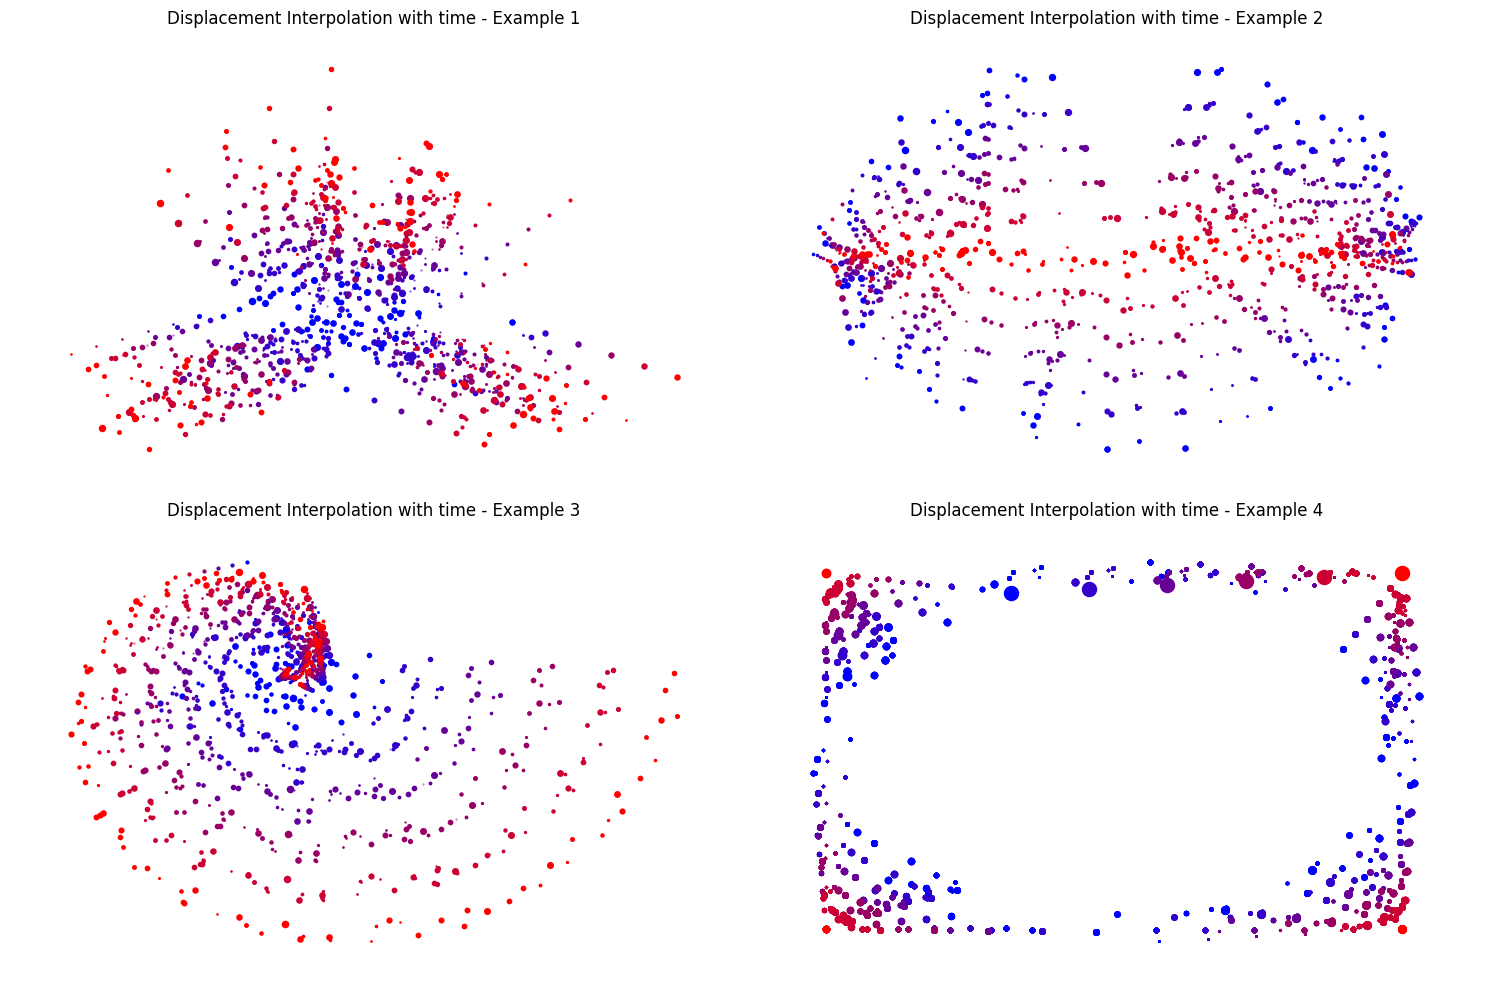

In [52]:
plot_interpolations([(X_1, Y_1, I_1, J_1, Pij_1), (X_2, Y_2, I_2, J_2, Pij_2), (X_3, Y_3, I_3, J_3, Pij_3), (X_4, Y_4, I_4, J_4, Pij_4)], num_cols=2)

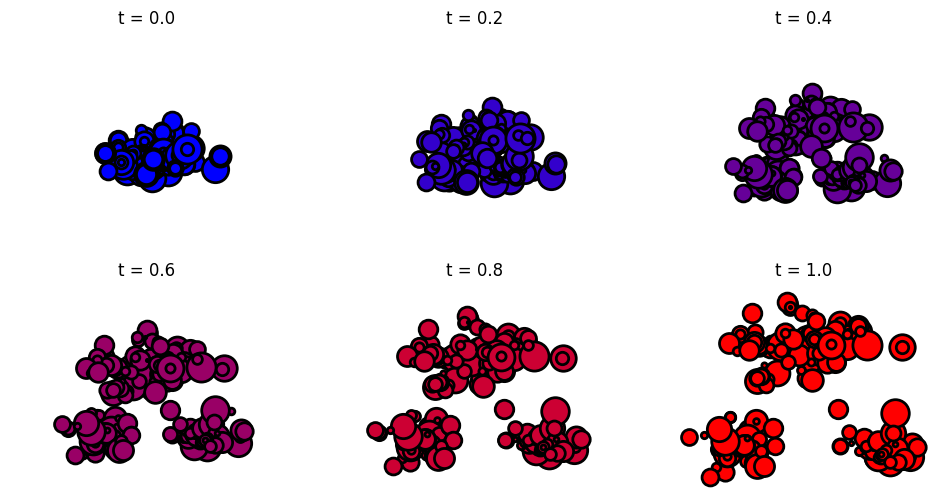

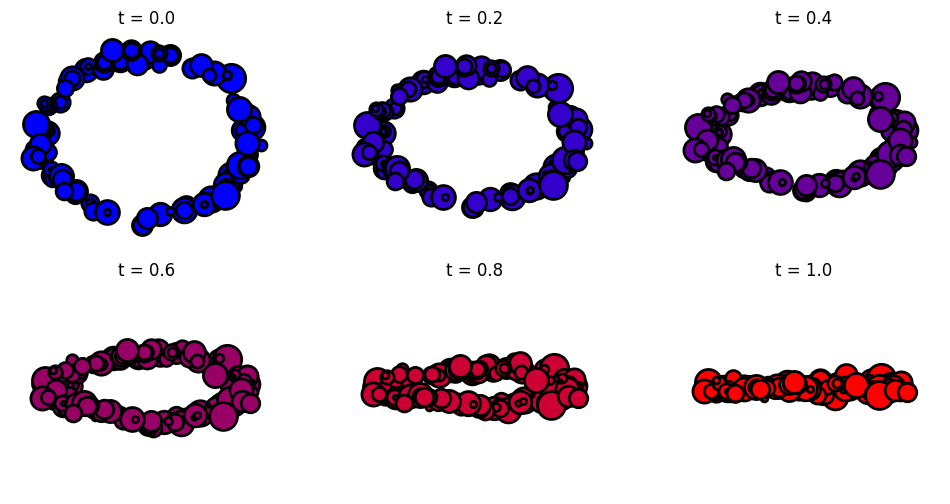

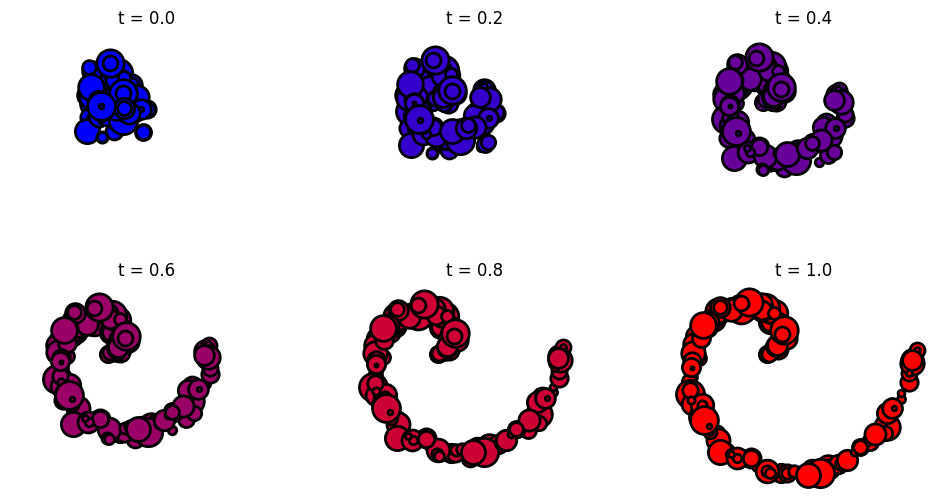

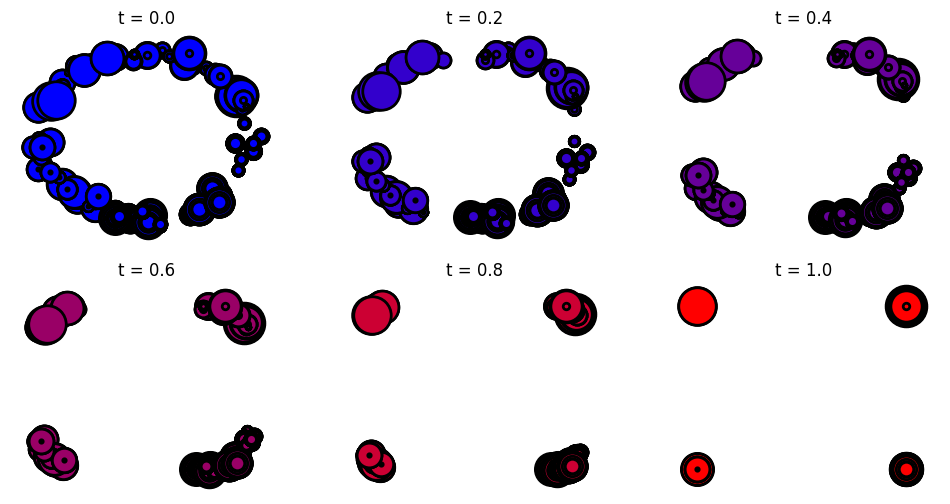

In [19]:
plot_interpolation(X_1, Y_1, I_1, J_1, Pij_1)
plot_interpolation(X_2, Y_2, I_2, J_2, Pij_2)
plot_interpolation(X_3, Y_3, I_3, J_3, Pij_3)
plot_interpolation(X_4, Y_4, I_4, J_4, Pij_4)

Optimal Assignement
-------------------
In the case where $n=m$ and the weights are uniform $a_{i}=1/n, b_{j}=1/n$, one can show that there is at least one optimal transport coupling which is actually a
permutation matrix. This properties comes from the fact that
the extremal point of the polytope $U(1,1)$ are permutation matrices.


This means that there exists an optimal permutation $\si^\star \in \Sigma_n$ such
that
$$ P^\star_{i,j} = \choice{
      1 \qifq j=\si^\star(i), \\
      0 \quad\text{otherwise}.
  } $$
  
where $\Si_n$ is the set of permutation (bijections) of
$\{1,\ldots,n\}$.


This permutation thus solves the so-called optimal assignement problem
$$ \si^\star \in \uargmin{\si \in \Sigma_n}
      \sum_{i} C_{i,\si(j)}. $$

Use the same number of points.

In [20]:
n = 40
m = n

Compute points clouds.

In [46]:
X_1 = np.random.randn(2,n)*.3
Y_1 = np.hstack((gauss(int(m/2),.5,[0,1.6]),np.hstack((gauss(int(m/4),.3,[-1,-1]),gauss(int(m/4),.3,[1,-1])))))

theta = np.random.rand(n)*2*np.pi
X_2 = [np.cos(theta), np.sin(theta)] + np.random.randn(2,n)*.05 #Cercle bruité
Y_2 = [np.random.rand(m)*2-1, np.zeros(m)] + np.random.randn(2,m)*.05

t = np.linspace(0, 2 * np.pi, m)
r = a_ * t
X_3 = np.random.randn(2,n)*.3
Y_3 = np.stack((r * np.cos(t), r * np.sin(t)), axis=1).T + (np.random.randn(2, m)*sigma) #Spirale bruitée

theta_bis = np.random.rand(n)*2*np.pi
X_4 = [np.cos(theta_bis), np.sin(theta_bis)] + np.random.randn(2,n)*.05 #Cercle bruité
Y_4 = np.array(random.choices([[-1,1],[1,-1],[-1,-1],[1,1]], k=m)).T

Constant distributions.

In [47]:
a = np.ones([n,1])/n
b = a

Compute the weight matrix $ (C_{i,j})_{i,j}. $

In [48]:
C_1 = distmat(X_1,Y_1)
C_2 = distmat(X_2,Y_2)
C_3 = distmat(X_3,Y_3)
C_4 = distmat(X_4,Y_4)

Display the coulds.

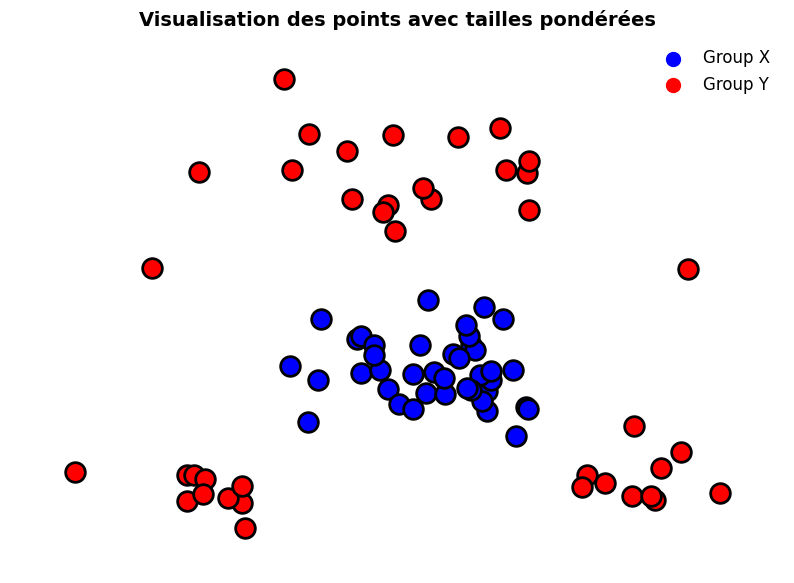

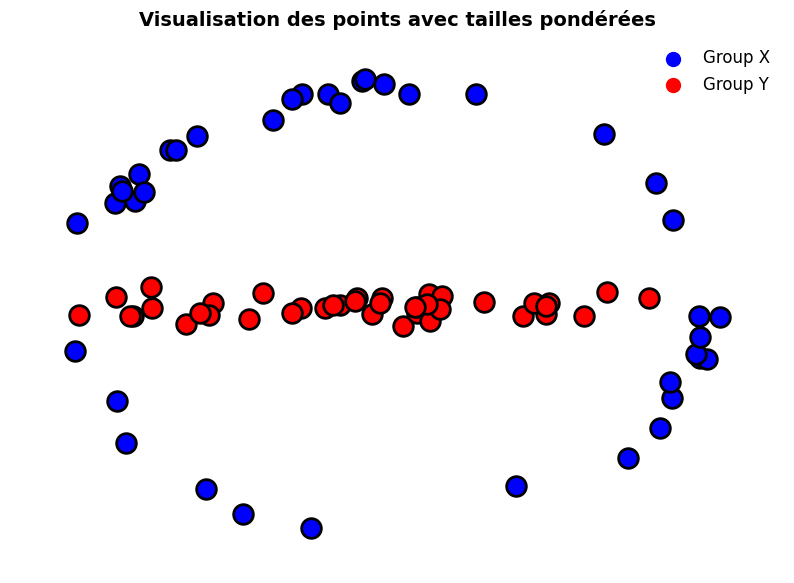

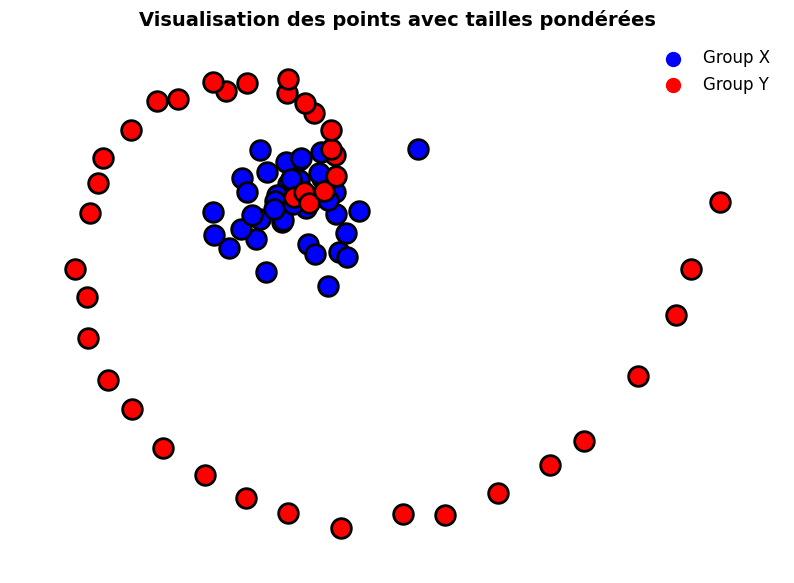

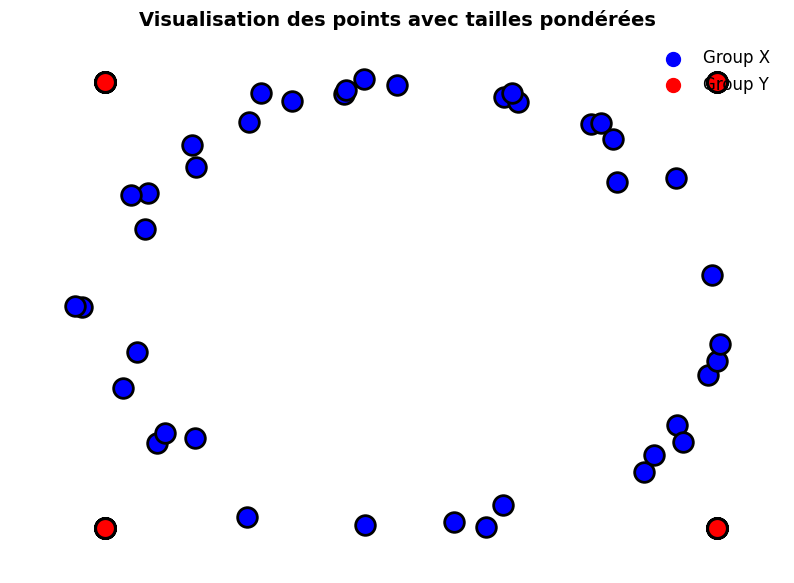

In [49]:
plot_points(X_1, Y_1, a, b)
plot_points(X_2, Y_2, a, b)
plot_points(X_3, Y_3, a, b)
plot_points(X_4, Y_4, a, b)

Solve the optimal transport.

In [50]:
P_1 = cp.Variable((n,m))
P_2 = cp.Variable((n,m))
P_3 = cp.Variable((n,m))
P_4 = cp.Variable((n,m))
u = np.ones((m,1))
v = np.ones((n,1))
U_1 = [0 <= P_1, cp.matmul(P_1,u)==a, cp.matmul(P_1.T,v)==b]
objective = cp.Minimize( cp.sum(cp.multiply(P_1,C_1)) )
prob = cp.Problem(objective, U_1)
result_1 = prob.solve()

U_2 = [0 <= P_2, cp.matmul(P_2,u)==a, cp.matmul(P_2.T,v)==b]
objective = cp.Minimize( cp.sum(cp.multiply(P_2,C_2)) )
prob = cp.Problem(objective, U_2)
result_2 = prob.solve()

U_3 = [0 <= P_3, cp.matmul(P_3,u)==a, cp.matmul(P_3.T,v)==b]
objective = cp.Minimize( cp.sum(cp.multiply(P_3,C_3)) )
prob = cp.Problem(objective, U_3)
result_3 = prob.solve()

U_4 = [0 <= P_4, cp.matmul(P_4,u)==a, cp.matmul(P_4.T,v)==b]
objective = cp.Minimize( cp.sum(cp.multiply(P_4,C_4)) )
prob = cp.Problem(objective, U_4)
result_4 = prob.solve()

Show that $P$ is a binary permutation matrix.

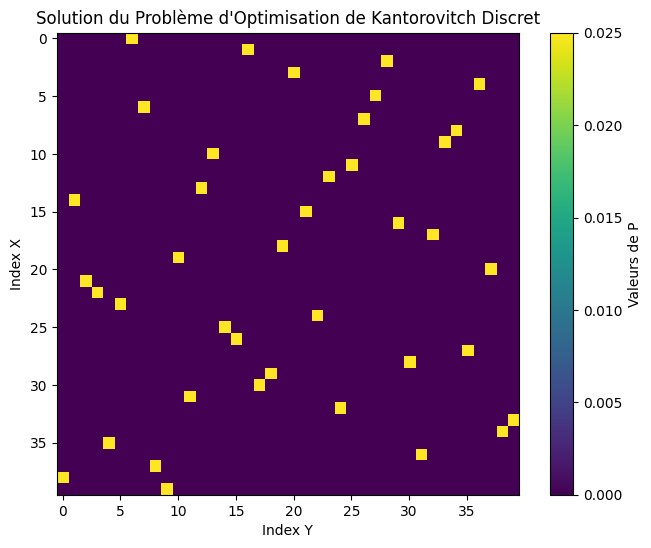

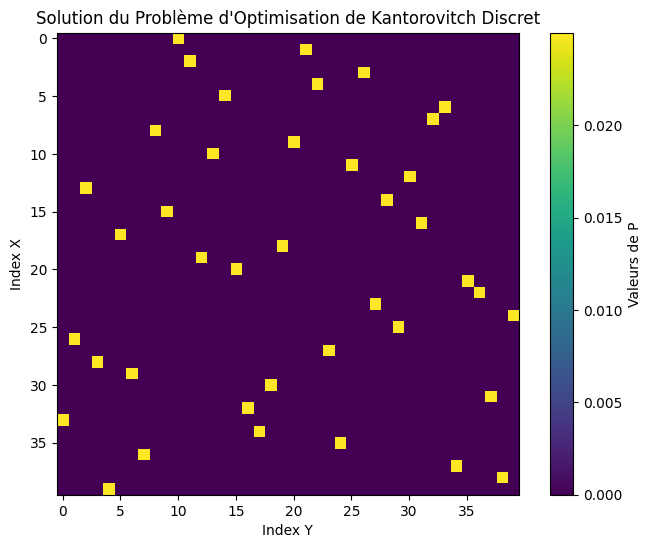

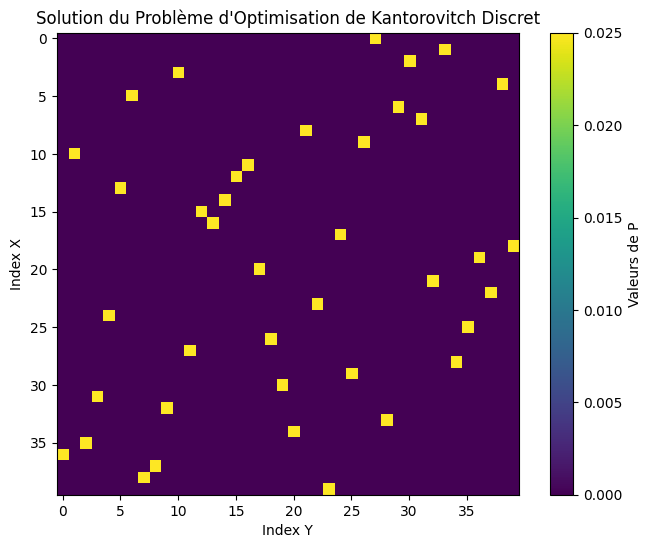

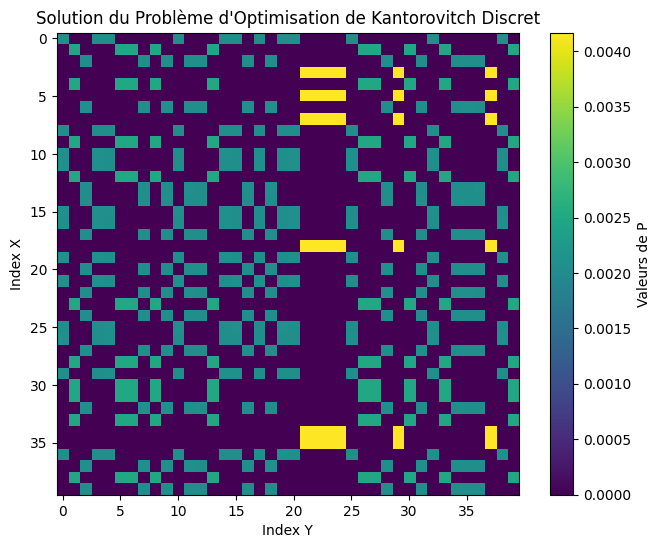

In [51]:
plot_solution(P_1)
plot_solution(P_2)
plot_solution(P_3)
plot_solution(P_4)

Display the optimal assignement.

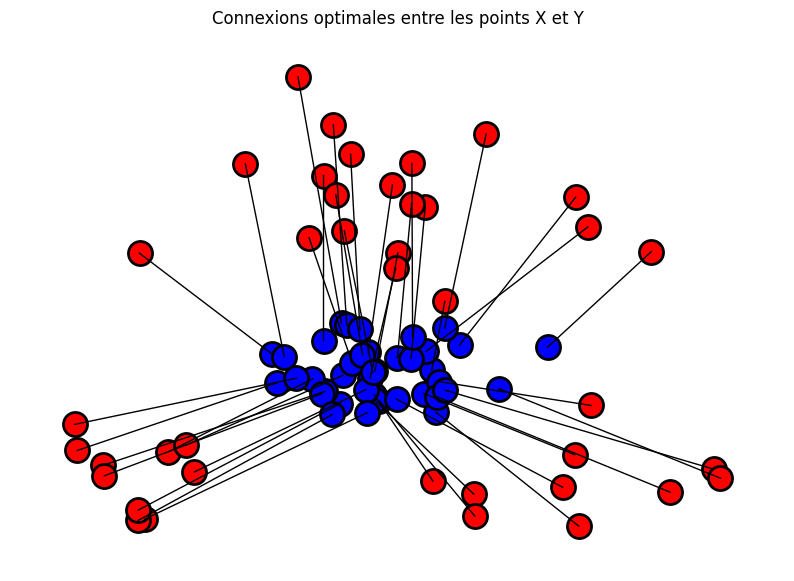

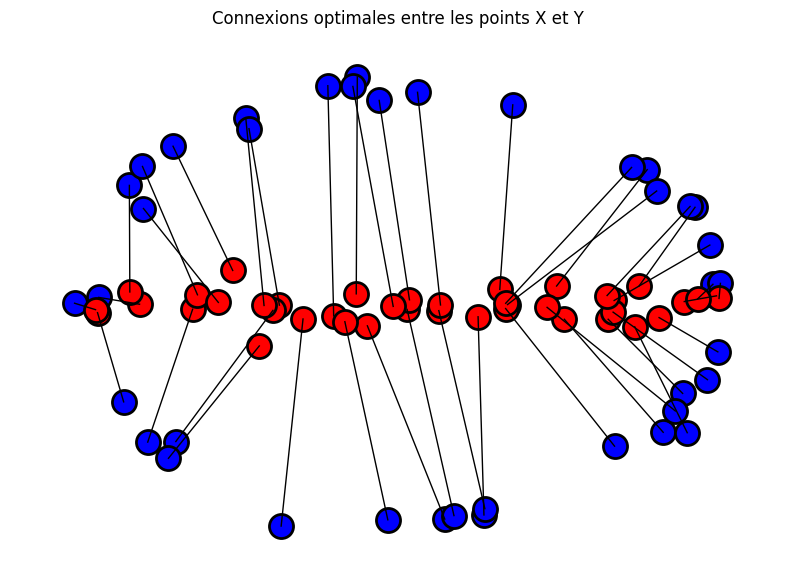

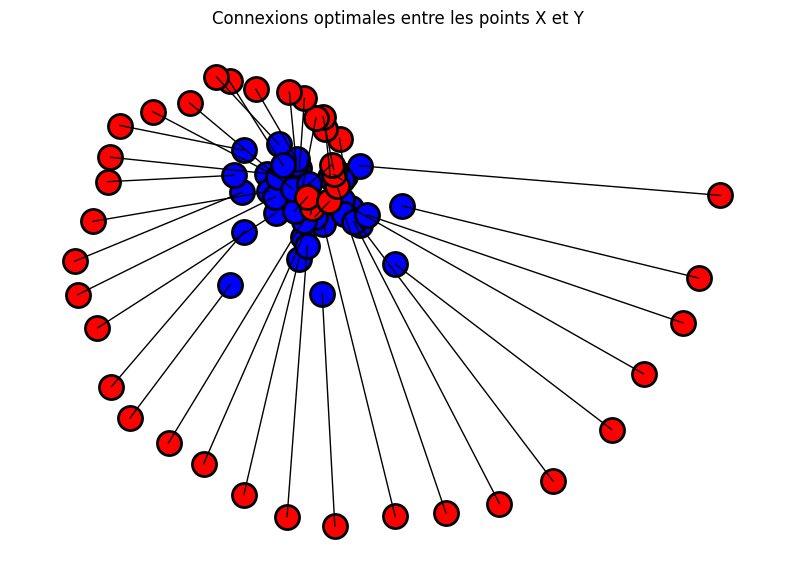

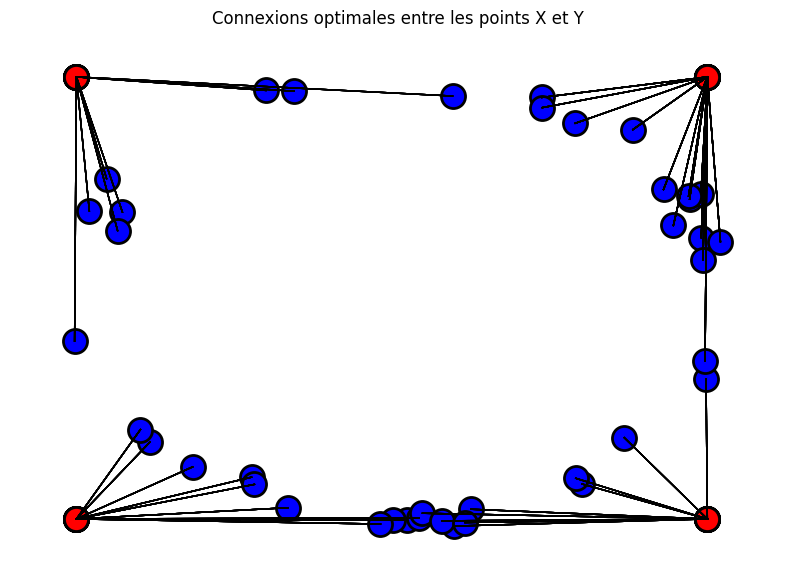

In [32]:
plot_matching(X_1, Y_1, P_1)
plot_matching(X_2, Y_2, P_2)
plot_matching(X_3, Y_3, P_3)
plot_matching(X_4, Y_4, P_4)